# Autoencoder for MNIST compared to supervised model

### Imports and load the MNIST dataset

In [24]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Exstract input shape
input_shape = x_train.shape[1:] # (28, 28)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


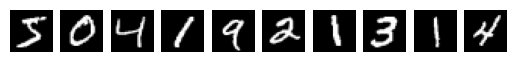

In [25]:
# Plot the first 10 images
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.axis('off')

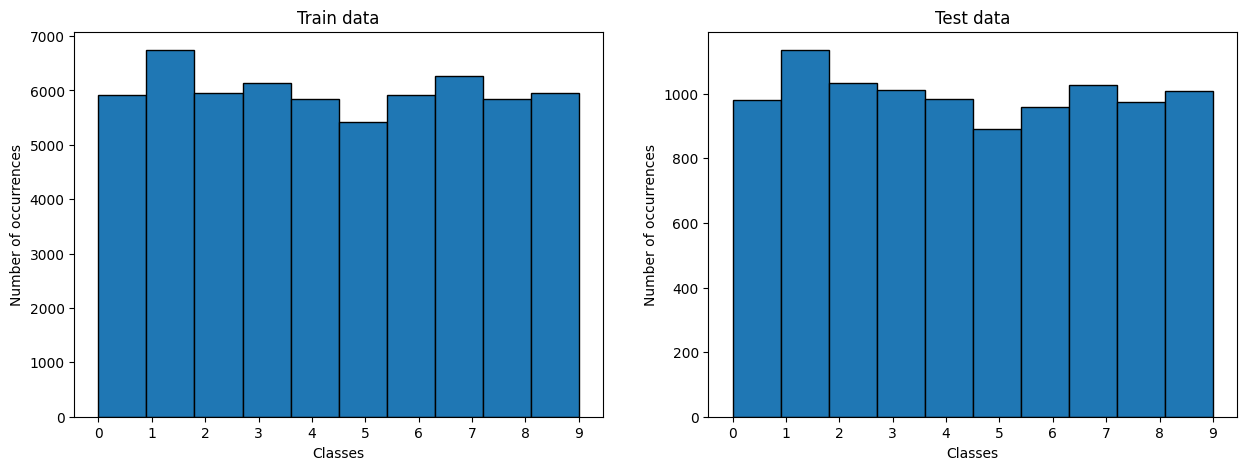

In [26]:
fig, axs = plt.subplots(1,2,figsize=(15,5)) 
axs[0].hist(y_train, ec='black')
axs[0].set_title('Train data')
axs[0].set_xlabel('Classes') 
axs[0].set_ylabel('Number of occurrences')
axs[1].hist(y_test, ec='black')
axs[1].set_title('Test data')
axs[1].set_xlabel('Classes') 
axs[1].set_ylabel('Number of occurrences')
# We want to show all ticks...
axs[0].set_xticks(np.arange(10))
axs[1].set_xticks(np.arange(10))

plt.show()

### Vector size for latent variables and number of epochs

In [27]:
LATENT_SIZE = 32
EPOCHS = 100

### Define the autoencoder model consisting of an encoder and decoder

In [28]:
# Autoencoder using CNN layers
encoder = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((28, 28, 1), input_shape=input_shape),
    tf.keras.layers.Conv2D(16, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(LATENT_SIZE, activation="relu")
])

decoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(7 * 7 * 32, input_shape=(LATENT_SIZE,)),
    tf.keras.layers.Reshape((7, 7, 32)),
    tf.keras.layers.Conv2DTranspose(32, (3, 3), activation="relu", padding="same"),
    tf.keras.layers.UpSampling2D((2, 2)),
    tf.keras.layers.Conv2DTranspose(16, (3, 3), activation="relu", padding="same"),
    tf.keras.layers.UpSampling2D((2, 2)),
    tf.keras.layers.Conv2DTranspose(1, (3, 3), activation="sigmoid", padding="same"),
    tf.keras.layers.Reshape((28, 28))
])

img = tf.keras.layers.Input(shape = input_shape)
latent_vector = encoder(img)
output = decoder(latent_vector)
autoencoder = tf.keras.models.Model(inputs = img, outputs = output)

### Compile and train the autoencoder

In [32]:
autoencoder.compile("nadam", loss = "binary_crossentropy")

history = autoencoder.fit(x_train, x_train, epochs=EPOCHS)

Epoch 1/100
1875/1875 [==============================] - 37s 19ms/step - loss: 0.0816
Epoch 2/100
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0808
Epoch 3/100
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0802
Epoch 4/100
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0798
Epoch 5/100
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0794
Epoch 6/100
1875/1875 [==============================] - 31s 16ms/step - loss: 0.0791
Epoch 7/100
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0788
Epoch 8/100
1875/1875 [==============================] - 33s 17ms/step - loss: 0.0786
Epoch 9/100
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0784
Epoch 10/100
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0782
Epoch 11/100
1875/1875 [==============================] - 35s 19ms/step - loss: 0.0781
Epoch 12/100
1875/1875 [============================

### Plot the autoencoder loss

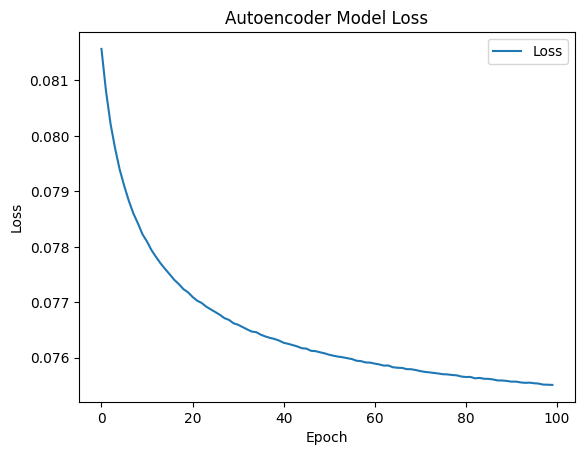

In [33]:
plt.plot(history.history['loss'])
plt.title('Autoencoder Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss'], loc='upper right')
plt.show()

### Fine-tune the model with supervised learning with 10% of the training data

(600, 28, 28)
(600,)


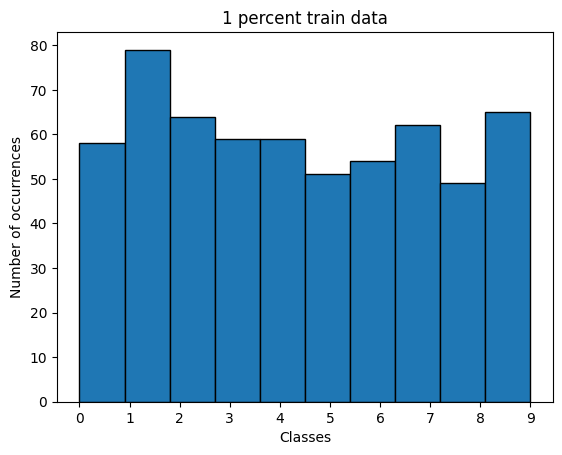

In [34]:
# Use 1% of the labeled training examples for supervised learning
x_train_supervised = x_train[:600]
y_train_supervised = y_train[:600]

print(x_train_supervised.shape)
print(y_train_supervised.shape)

plt.plot(figsize=(10,5)) 
plt.hist(y_train_supervised, ec='black')
plt.title('1 percent train data')
plt.xlabel('Classes') 
plt.ylabel('Number of occurrences')
plt.xticks(np.arange(10))
plt.show()

In [38]:
# Set up the model
fine_tune_model = tf.keras.models.Sequential([
    encoder,
    tf.keras.layers.Dense(10, activation="softmax")
])

# Compile the model
fine_tune_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Train the model
history_autoencoder = fine_tune_model.fit(
    x_train_supervised,
    y_train_supervised,
    epochs=EPOCHS,
    verbose=0
)

# Evaluate the model on the test set
_, accuracy_autoencoder = fine_tune_model.evaluate(x_test, y_test, verbose=0)
print(f"Accuracy after fine-tuning: {accuracy_autoencoder}")

Accuracy after fine-tuning: 0.8916000127792358


## Training a CNN model supervised on 1% of the labeled data

In [39]:
# Set up the model
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((28, 28, 1), input_shape=input_shape),
    tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

# Compile the model
cnn_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Train the model
history_cnn = cnn_model.fit(
    x_train_supervised,
    y_train_supervised,
    epochs=EPOCHS,
    verbose=0
)

# Evaluate the model on the test set
_, accuracy_cnn = cnn_model.evaluate(x_test, y_test, verbose=0)
print(f"Accuracy after fine-tuning: {accuracy_cnn}")

Accuracy after fine-tuning: 0.9276999831199646


### Plot the history accuracy of the two models

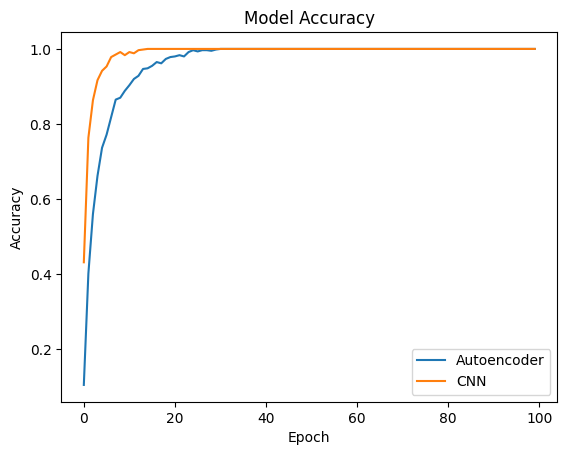

In [40]:
plt.plot(history_autoencoder.history['accuracy'])
plt.plot(history_cnn.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Autoencoder', 'CNN'], loc='lower right')
plt.show()

### Compare the performance of the autoencoder and CNN models

In [41]:
print(f'Unsupervised CNN autoencoder with supervised fine-tuning accuracy: {accuracy_autoencoder}')
print(f'Supervised CNN accuracy: {accuracy_cnn}')
print()

if accuracy_autoencoder > accuracy_cnn:
    print(f'Unsupervised CNN autoencoder with supervised fine-tuning performs better after {EPOCHS} unsupervised ephocs, and {EPOCHS} supervised epochs.')
else:
    print(f'Supervised CNN is better after {EPOCHS} supervised epochs')

Unsupervised CNN autoencoder with supervised fine-tuning accuracy: 0.8916000127792358
Supervised CNN accuracy: 0.9276999831199646

Supervised CNN is better after 100 supervised epochs


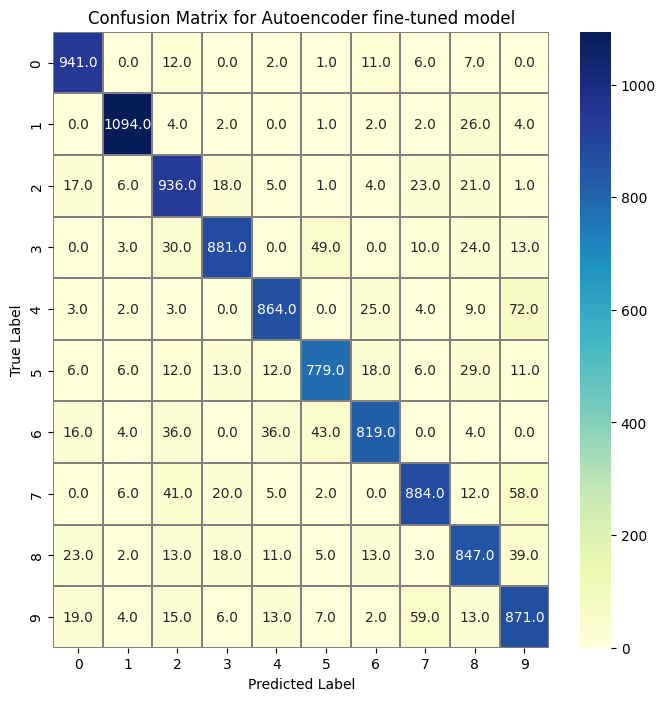

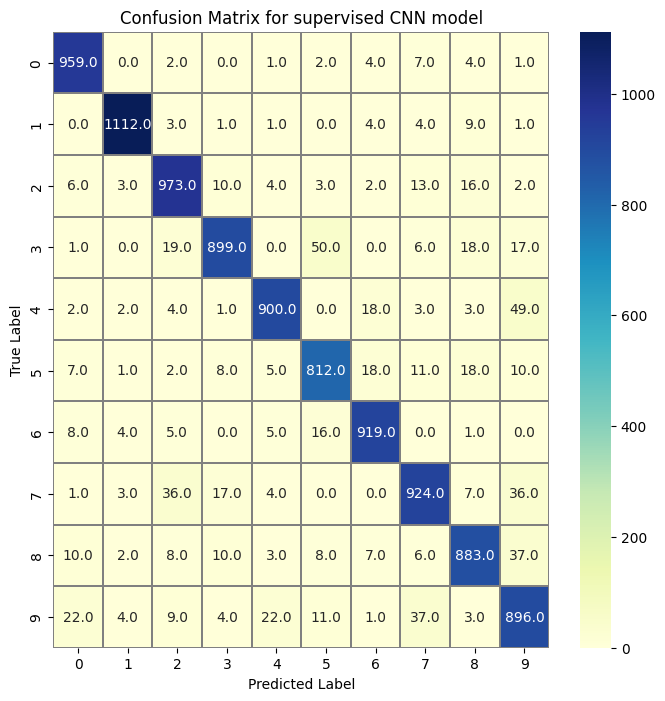

In [42]:
# Seaborn heatmap of confusion matrix

# Predict the values from the validation dataset
Y_pred = fine_tune_model.predict(x_test, verbose=0)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = y_test

# Compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred_classes)

# Plot the confusion matrix
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="YlGnBu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Autoencoder fine-tuned model")


# Do the same for the CNN model
# Predict the values from the validation dataset
Y_pred = cnn_model.predict(x_test, verbose=0)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = y_test

# Compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred_classes)

# Plot the confusion matrix
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="YlGnBu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for supervised CNN model")
plt.show()